In [1]:
import os
import imp
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import sys
import pickle as plk
import importlib.util

###############################################################
# LINUX PATH

sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/fotonica04/Documentos/GitHub/Photonics-training/Projects/Hybrid4x4/SimulationFiles')) #Current directory


###############################################################
# WINDOWS PATH

# spec_win = importlib.util.spec_from_file_location('lumapi', 'C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')
# lumapi = importlib.util.module_from_spec(spec_win)
# os.add_dll_directory("C:/Program Files/Lumerical/v202/api/python")
# sys.path.append(os.path.dirname('C:/Users/Caio/Documents/GitHub/Photonics-training/Projects/Hybrid4x4/SimulationFiles/'))
# spec_win.loader.exec_module(lumapi)

## Lumapi init

In [2]:
mmi = lumapi.MODE()  

## Functions

In [11]:
# Search for function's intersections on signal levels
def signalLv(yarray,level,type):
    peak, pd = find_peaks(yarray)
    maxpeak = yarray[peak[np.argmax(yarray[peak])]]
    minpeak = yarray[np.argmin(yarray)]
    index = []

    if(type == 'linear'):
        lvpeak = (maxpeak - minpeak)*level + minpeak
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = (yarray[index[0]] + yarray[index[-1]])/2

    if(type == 'log10'):
        lvpeak = maxpeak + 10*np.log10(level)
        for i in range(0,np.size(yarray)-1):
            if(((maxpeak-yarray[i]) - (maxpeak-lvpeak)) * ((maxpeak-yarray[i+1]) - (maxpeak-lvpeak)) <= 0):
                index.append(i)
        yMed = 10*np.log10((10**(yarray[index[0]]/2) + 10**(yarray[index[1]]/2))/2)

    return {'index':index,'yMed':yMed}


# Creates a box
def RectInsert(X,XSPAN,Y,YSPAN,Z,ZSPAN,MATERIAL,lumerical):
    
    lumerical.switchtolayout()
    lumerical.addrect()
    lumerical.set({"x":X,"y":Y,"z":Z,
         "x span":XSPAN, "y span":YSPAN, "z span":ZSPAN,
         "material":MATERIAL
        })


# Format a function/dataset as a polygon
def PolyForm(x,y,ybase):
    y2 = y + ybase
    A = np.zeros((2,len(x)+2))
    
    A[0][1:len(x)+1] = x
    A[1][1:len(x)+1] = y2
    A[0][0] = x[0]
    A[0][len(x)+1] = x[-1]
    A[1][0] = ybase
    A[1][len(x)+1] = ybase
    
    return A

## Assembly parameters

In [20]:
# Body config------------------------------------
BdX_Span = 178e-6 # Body X Span
BdY_Span = 10e-6 # Body y Span


# Ports config-----------------------------------

OutMx = [3.8e-6,-3.8e-6,1.2e-6,-1.2e-6]              # Array of output ports y positions (put 0 on first element to ignore this line)
InMx = [3.8e-6,-3.8e-6,1.2e-6,-1.2e-6]               # Array of input ports y positions (put 0 on first element to ignore this line) 

# If the lines above has to be ignored, use these ones instead: 
InP = 4 # Number of Input ports
OutP = 4 # Number of Output ports
Asy = 0 # Force asymmetry on inputs ports auto-displacement (0 -> Symetry, 1 -> Asymmetry)
         
PYSpan_in = 2.4e-6 # Input Port Y Span 
PYSpan_out = 2.4e-6 # Output Port Y Span 


# Tappers config---------------------------------
SetToTappers = 1 # Set tappers as inputs/outputs
TLen = 6e-6 # Tapper Length
TWidth = 2e-6 # Tapper Width

# Bends config---------------------------------
SBended = 1 # enable S-bends on ports
SBxsp = 8e-6 # S-bend xspan
SBysp = 6e-6 # S-bend yspan


# Mesh config------------------------------------
MeshEnableIn = 1 # enable input mesh insertion
MeshEnableOut = 1 # enable output mesh insertion

MeshOver = [[0.05e-6,0.05e-6,0.1e-6] , [0.05e-6,0.05e-6,0.1e-6]] # Override mesh value dx,dy and dz ([[Input Mesh],[Output Mesh]])
MeshMultiplier = [[4,4,4] , [4,4,4]] # Mesh multipler value dx,dy and dz ([[Input Mesh],[Output Mesh]])
    

# EME config-------------------------------------
EME_MC = 400 # Number of EME Mesh Cells (Y and Z)
SideCells = 20 # Number of Cells on Input/Output groups

## Assembly

In [21]:
# General & Body settings -----------------------------------

mmi.switchtolayout()
mmi.selectall()
mmi.delete()

TLen = TLen*SetToTappers

if InMx[0] != 0:
    InP = len(InMx)
if OutMx[0] != 0:
    OutP = len(OutMx)

RectInsert(BdX_Span/2,BdX_Span, 0,BdY_Span, 0e-6,0.22e-6,
"Si (Silicon) - Palik",mmi)
mmi.set("name","MMI Body")

RectInsert(BdX_Span/2, BdX_Span+TLen*2+8e-6, 0, BdY_Span*1.5, -0.52e-6, 0.82e-6,
"SiO2 (Glass) - Palik",mmi)
mmi.set("name","Substrate")

# Input/Output ports setting --------------------------------

for i in range(1,InP+1):
    if(InMx[0]==0):
        InY = (i/((Asy+1)*(InP+1))-0.5)*BdY_Span*(1-2*Asy)**i
    else:
        InY = InMx[i-1]
        RectInsert(-TLen-2e-6,4e-6 , InY,0.48e-6, 0,0.22e-6,
        "Si (Silicon) - Palik",mmi)
        mmi.set("name","MMI EnterPort "+ str(i))

for i in range(1,OutP+1):
    if(OutMx[0]==0):
        OutY = (i/(OutP+1)-0.5)*BdY_Span
    else:
        OutY = OutMx[i-1]

    RectInsert(BdX_Span+TLen+2e-6,4e-6, OutY,0.48e-6, 0,0.22e-6,
    "Si (Silicon) - Palik",mmi)
    mmi.set("name","MMI OutPort "+ str(i))


if(SetToTappers == 1):
    for i in range(1,InP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":180,
             "x":-TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth,  
             "angle_side":90,  
             "name":"Input Taper "+ str(i)})
        InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
        mmi.set("y",InY)
  
    for i in range(1,OutP+1):
        mmi.addobject("linear_taper")
        mmi.set({"first axis":"z", "rotation 1":0,
             "x":BdX_Span+TLen/2, "z":0, "len":TLen,
             "thickness":0.22e-6,
             "width_l":TWidth, 
             "angle_side":90, 
             "name":"Output Taper "+ str(i)})
        OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
        mmi.set("y",OutY)


# Mesh setting -------------------------------------
if(MeshEnableIn == 1):
    for i in range(InP):
        mmi.addmesh()
        mmi.set({"x":-2e-6-TLen/4, "x span":4e-6 + TLen/2,
                "y span":TWidth, "z":0, "z span":1e-6})
        InY = mmi.getnamed("MMI EnterPort "+ str(i+1),"y")
        mmi.set("y",InY)
        mmi.set("name","input_mesh " + str(i+1))
        mmi.set({"dx":MeshOver[0][0], "dy":MeshOver[0][1], "dz":MeshOver[0][2]})

if(MeshEnableOut == 1):
    for i in range(OutP):
        mmi.addmesh()
        mmi.set({"x":BdX_Span + 2e-6+TLen/4, "x span":4e-6 + TLen/2,
                 "y span":TWidth, "z":0, "z span":1e-6})
        OutY = mmi.getnamed("MMI OutPort "+ str(i+1),"y")
        mmi.set("y",OutY)
        mmi.set("name","output_mesh " + str(i+1))


# EME setting ----------------------------------------------
mmi.addeme()

mmi.set({"allow custom eigensolver settings":1 ,"display cells":1, "number of cell groups":3, "wavelength":1547.5e-9})
mmi.set("group spans",np.transpose([(1.3*TLen+4e-6)/2, BdX_Span, (1.3*TLen+4e-6)/2]))      
mmi.set({"cells":np.transpose([SideCells, 1, SideCells]),
         "subcell method":np.transpose([1, 0, 1]), # 0 = none,  1 = CVCS
         "modes":np.transpose([25, 30, 25])})

mmi.set({"x min":(-1.3*TLen-4e-6)/2 ,
     "y":0, "y span":1.4*BdY_Span,
     "z":0, "z span":1e-6})

mmi.set({"y min bc":"PML", "y max bc":"PML",
     "z min bc":"Symmetric", "z max bc":"PML",
     "mesh cells y":EME_MC, "mesh cells z":EME_MC})


# EME Ports setting -----------------------------------------
mmi.selectpartial("EME::Ports::port")
mmi.delete()
for i in range(1,InP+1):
    mmi.addemeport()
    InY = mmi.getnamed("MMI EnterPort "+ str(i),"y")
    mmi.set({"use full simulation span":0,
    "port location":"left",
    "y":InY, "y span":PYSpan_in,
    "z":0, "z span":4e-6})
  
for i in range(1,OutP+1):
    mmi.addemeport()
    OutY = mmi.getnamed("MMI OutPort "+ str(i),"y")
    mmi.set({"use full simulation span":0,
    "port location":"right",
    "y":OutY, "y span":PYSpan_out,
    "z":0, "z span":4e-6})  


# Monitor setting -----------------------------------------
mmi.addemeprofile()
mmi.set({"x":BdX_Span/2, "x span":BdX_Span+1.3*TLen+4e-6, "y span":1.4*BdY_Span})

## Get imbalance and excess loss

In [23]:
mmi.setemeanalysis('wavelength sweep',1)
mmi.setemeanalysis('start wavelength',1520e-9)
mmi.setemeanalysis('stop wavelength',1565e-9)
mmi.setemeanalysis('number of wavelength points',90)
mmi.emesweep('wavelength sweep')

LumApiError: 'Operation on closed application'

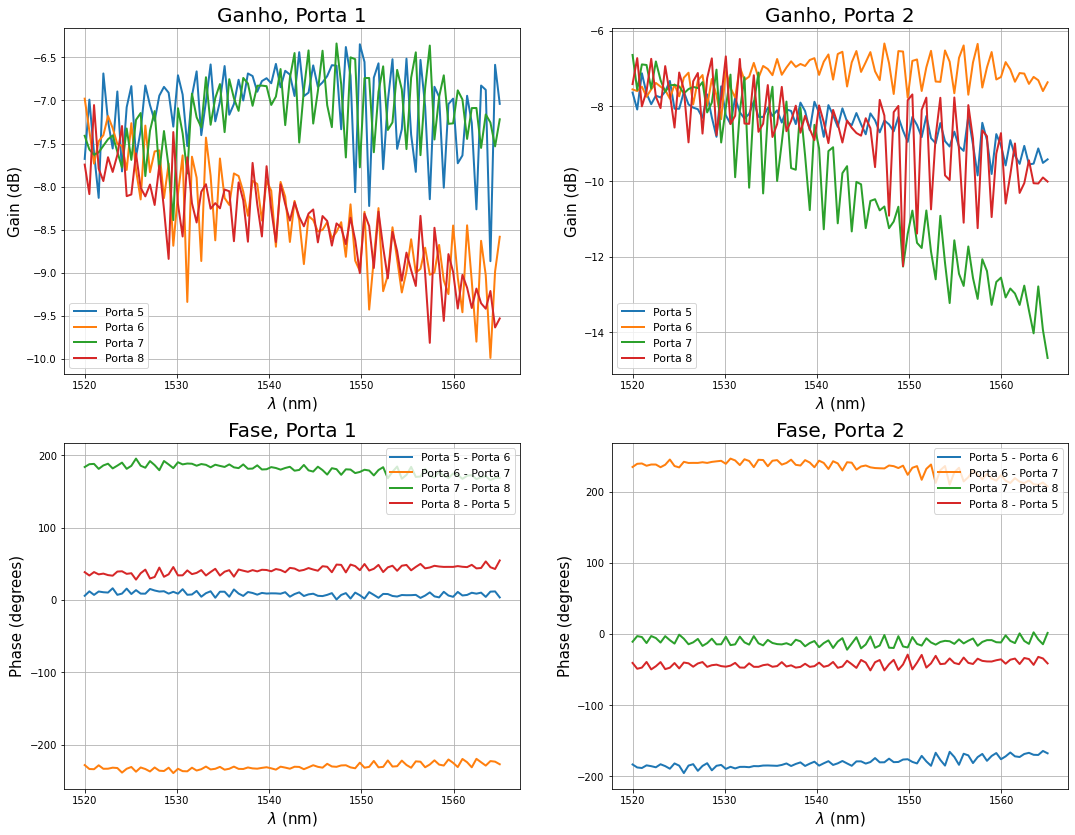

In [15]:
S= mmi.getemesweep('S_wavelength_sweep')
S.keys()
fig, ax= plt.subplots(2,2,figsize=(18,14))
ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s51']**2)),linewidth = 2,label = 'Porta 5')
ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s61']**2)),linewidth = 2,label = 'Porta 6')
ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s71']**2)),linewidth = 2,label = 'Porta 7')
ax[0][0].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s81']**2)),linewidth = 2,label = 'Porta 8')
ax[0][0].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[0][0].set_ylabel(r'Gain (dB)',fontsize =15)
ax[0][0].set_title('Ganho, Porta 1',fontsize =20)
ax[0][0].legend(fontsize = 11)
ax[0][0].grid()

ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s54']**2)),linewidth = 2,label = 'Porta 5')
ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s64']**2)),linewidth = 2,label = 'Porta 6')
ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s74']**2)),linewidth = 2,label = 'Porta 7')
ax[0][1].plot(S['wavelength']*1e9,10*np.log10(np.abs(S['s84']**2)),linewidth = 2,label = 'Porta 8')
ax[0][1].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[0][1].set_ylabel(r'Gain (dB)',fontsize =15)
ax[0][1].set_title('Ganho, Porta 2',fontsize =20)
ax[0][1].legend(fontsize = 11)
ax[0][1].grid()

ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s51'])) - np.unwrap(np.angle(S['s61'])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s61'])) - np.unwrap(np.angle(S['s71'])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s71'])) - np.unwrap(np.angle(S['s81'])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
ax[1][0].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s81'])) - np.unwrap(np.angle(S['s51'])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][0].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[1][0].set_ylabel(r'Phase (degrees)',fontsize =15)
ax[1][0].set_title('Fase, Porta 1',fontsize =20)
ax[1][0].legend(fontsize = 11)
ax[1][0].grid()

ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s54'])) - np.unwrap(np.angle(S['s64'])))/np.pi,linewidth = 2,label = 'Porta 5 - Porta 6')
ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s64'])) - np.unwrap(np.angle(S['s74'])))/np.pi,linewidth = 2,label = 'Porta 6 - Porta 7')
ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s74'])) - np.unwrap(np.angle(S['s84'])))/np.pi,linewidth = 2,label = 'Porta 7 - Porta 8')
ax[1][1].plot(S['wavelength']*1e9,180*(np.unwrap(np.angle(S['s84'])) - np.unwrap(np.angle(S['s54'])))/np.pi,linewidth = 2,label = 'Porta 8 - Porta 5')
ax[1][1].set_xlabel(r'$\lambda$ (nm)',fontsize =15)
ax[1][1].set_ylabel(r'Phase (degrees)',fontsize =15)
ax[1][1].set_title('Fase, Porta 2',fontsize =20)
ax[1][1].legend(fontsize = 11)
ax[1][1].grid()

In [16]:
mmi.setemeanalysis('propagation sweep',1)
mmi.setemeanalysis('parameter','group span 2')
mmi.setemeanalysis('start',170e-6)
mmi.setemeanalysis('stop',190e-6)
mmi.setemeanalysis('number of points',80)
mmi.emesweep('propagation sweep')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


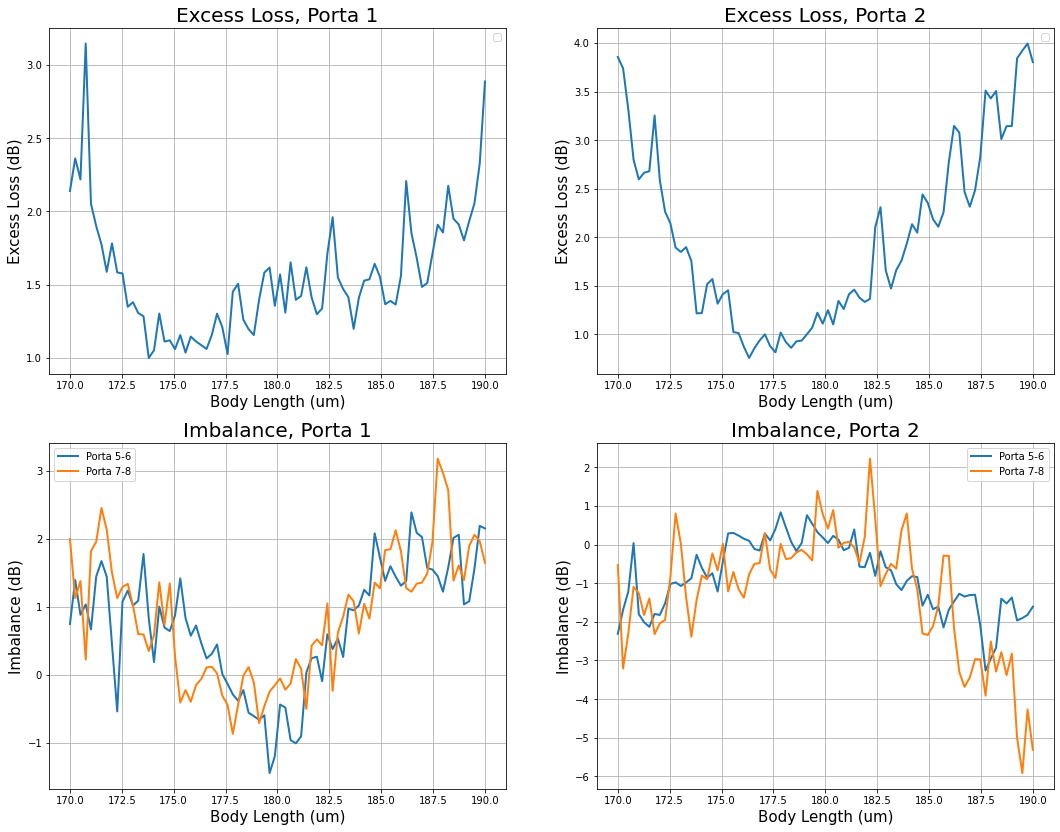

In [17]:
S= mmi.getemesweep('S')
#print(S.keys())

imb1_o5o6 = 10*np.log10(np.abs(S['s51'])**2 / np.abs(S['s61'])**2)
imb1_o7o8 = 10*np.log10(np.abs(S['s71'])**2 / np.abs(S['s81'])**2)
imb2_o5o6 = 10*np.log10(np.abs(S['s54'])**2 / np.abs(S['s64'])**2)
imb2_o7o8 = 10*np.log10(np.abs(S['s74'])**2 / np.abs(S['s84'])**2)

Exc1 = -10*np.log10( ( (np.abs(S['s51'])**2) + (np.abs(S['s61'])**2) + (np.abs(S['s71'])**2) + (np.abs(S['s81'])**2) ) )
Exc2 = -10*np.log10( ( (np.abs(S['s54'])**2) + (np.abs(S['s64'])**2) + (np.abs(S['s74'])**2) + (np.abs(S['s84'])**2) ) )

fig, ax= plt.subplots(2,2,figsize=(18,14))
ax[1][0].plot(S['group_span_2']*1e6,imb1_o5o6, linewidth = 2,label = 'Porta 5-6')
ax[1][0].plot(S['group_span_2']*1e6,imb1_o7o8, linewidth = 2,label = 'Porta 7-8')
ax[1][0].set_xlabel('Body Length (um)',fontsize =15)
ax[1][0].set_ylabel(r'Imbalance (dB)',fontsize =15)
ax[1][0].set_title('Imbalance, Porta 1',fontsize =20)
ax[1][0].legend()
ax[1][0].grid()

ax[0][0].plot(S['group_span_2']*1e6,Exc1, linewidth = 2)
ax[0][0].set_xlabel('Body Length (um)',fontsize =15)
ax[0][0].set_ylabel(r'Excess Loss (dB)',fontsize =15)
ax[0][0].set_title('Excess Loss, Porta 1',fontsize =20)
ax[0][0].legend()
ax[0][0].grid()

ax[1][1].plot(S['group_span_2']*1e6,imb2_o5o6, linewidth = 2,label = 'Porta 5-6')
ax[1][1].plot(S['group_span_2']*1e6,imb2_o7o8, linewidth = 2,label = 'Porta 7-8')
ax[1][1].set_xlabel('Body Length (um)',fontsize =15)
ax[1][1].set_ylabel(r'Imbalance (dB)',fontsize =15)
ax[1][1].set_title('Imbalance, Porta 2',fontsize =20)
ax[1][1].legend()
ax[1][1].grid()

ax[0][1].plot(S['group_span_2']*1e6,Exc2, linewidth = 2)
ax[0][1].set_xlabel('Body Length (um)',fontsize =15)
ax[0][1].set_ylabel(r'Excess Loss (dB)',fontsize =15)
ax[0][1].set_title('Excess Loss, Porta 2',fontsize =20)
ax[0][1].legend()
ax[0][1].grid()